# Task4-建模调参 

主要模型分为线性回归模型和非线形回归模型：
+ 线性回归模型

  最普遍的形式是$f(x)=ax+b$，其中x向量代表一条样本{x1,x2,x3....xn}，其中x1，x2，x3代表样本的各个特征，w是一条向量代表了每个特征所占的权重，b是一个标量代表特征都为0时的预测值。困难的地方在于我们如何获得w和b这两个向量，在李航老师的统计学习方法中把一个学习过程分为了三部分，模型、策略、算法，为了获得w和b我们需要制定一定的策略，而这个策略在机器学习的领域中，往往描述为真实值与回归值的偏差。$loss=(f(x)-y)^2$ 我们希望的是能够减少在测试集上的预测值f(x)与真实值y的差别，从而获得一个最佳的权重参数，因此这里采用最小二乘估计。
  
+ 决策树模型

+ GBDT模型

+ XGBoost模型

+ LightGBM模型

主要步骤如下：

step1 读取数据

step2 建模与评估
> <b>五折交叉验证</b>:在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（Cross Validation）


step3 模型调参

* [贪心算法](https://www.jianshu.com/p/ab89df9759c8)
> 对问题求解时，总是做出在当前看来是最好的选择。也就是说，不从整体最优上加以考虑，它所做出的仅仅是在某种意义上的局部最优解。
* [网格调参](https://blog.csdn.net/weixin_43172660/article/details/83032029)
> GridSearchCV：一种调参的方法，当你算法模型效果不是很好时，可以通过该方法来调整参数，通过循环遍历，尝试每一种参数组合，返回最好的得分值的参数组合
* [贝叶斯调参](https://blog.csdn.net/linxid/article/details/81189154)
> 贝叶斯优化通过基于目标函数的过去评估结果建立替代函数（概率模型），来找到最小化目标函数的值。贝叶斯方法与随机或网格搜索的不同之处在于，它在尝试下一组超参数时，会参考之前的评估结果，因此可以省去很多无用功。

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [4]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [5]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
model = LinearRegression(normalize=True)

In [8]:
model = model.fit(train_X, train_y)

In [9]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.341641892),
 ('v_8', 700675.5609398823),
 ('v_9', 170630.27723221408),
 ('v_7', 32322.661932028997),
 ('v_12', 20473.67079693847),
 ('v_3', 17868.07954148356),
 ('v_11', 11474.938996687828),
 ('v_13', 11261.764560010604),
 ('v_10', 2683.920090598847),
 ('gearbox', 881.8225039248246),
 ('fuelType', 363.90425072142494),
 ('bodyType', 189.6027101207286),
 ('city', 44.94975120522865),
 ('power', 28.55390161675519),
 ('brand_price_median', 0.5103728134078794),
 ('brand_price_std', 0.450363470926305),
 ('brand_amount', 0.14881120395066075),
 ('brand_price_max', 0.003191018670312298),
 ('SaleID', 5.355989919861131e-05),
 ('train', -1.1175870895385742e-08),
 ('seller', -2.7040368877351284e-07),
 ('offerType', -1.6549602150917053e-06),
 ('brand_price_sum', -2.1750068681876853e-05),
 ('name', -0.00029800127130892476),
 ('used_time', -0.002515894332847369),
 ('brand_price_average', -0.40490484510111163),
 ('brand_price_min', -2.2467753486889808),
 ('power_bin', -34.42064411728899

In [10]:
from matplotlib import pyplot as plt

In [11]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

The predicted price is obvious different from true price


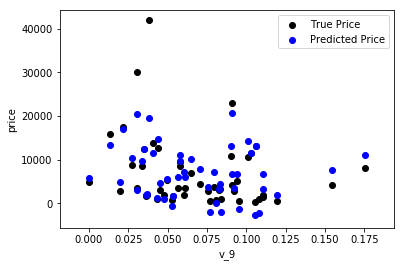

In [12]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

It is clear to see the price shows a typical exponential distribution


/Users/Tevain/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/Tevain/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


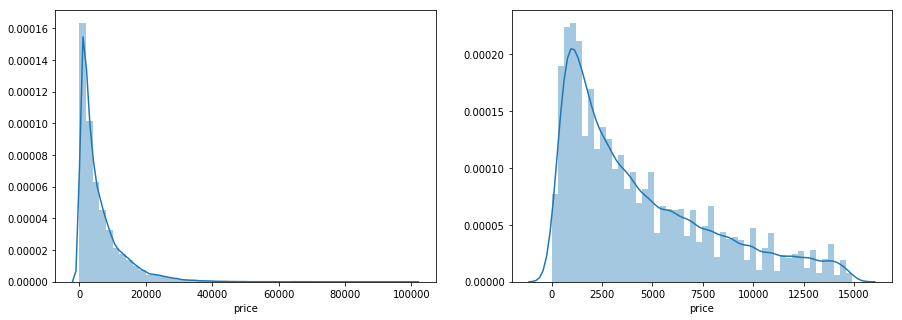

In [13]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [14]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


/Users/Tevain/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/Tevain/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


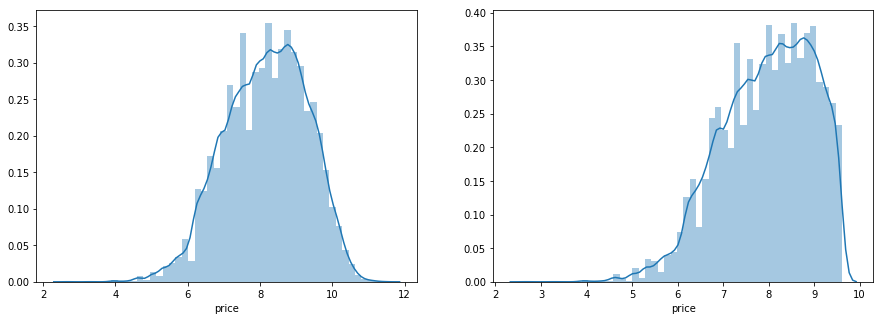

In [15]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [16]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.750749465574437


[('v_9', 8.052409900567705),
 ('v_5', 5.7642365966527045),
 ('v_12', 1.6182081236777799),
 ('v_1', 1.479831058298397),
 ('v_11', 1.166901656359277),
 ('v_13', 0.9404711296031496),
 ('v_7', 0.7137273083564193),
 ('v_3', 0.6837875771076581),
 ('v_0', 0.008500518010062918),
 ('power_bin', 0.008497969302893872),
 ('gearbox', 0.007922377278328122),
 ('fuelType', 0.0066847697068285064),
 ('bodyType', 0.004523520092702897),
 ('power', 0.0007161894205356957),
 ('brand_price_min', 3.334351114743906e-05),
 ('brand_amount', 2.897879704277462e-06),
 ('brand_price_median', 1.2571172873034224e-06),
 ('brand_price_std', 6.659176363461215e-07),
 ('brand_price_max', 6.194956307516807e-07),
 ('brand_price_average', 5.999345965030207e-07),
 ('SaleID', 2.1194170039651405e-08),
 ('train', -2.2737367544323206e-13),
 ('seller', -9.629630426388758e-12),
 ('offerType', -3.8536285273949034e-11),
 ('brand_price_sum', -1.5126504215921632e-10),
 ('name', -7.015512588883622e-08),
 ('used_time', -4.122479372352487e-

The predicted price seems normal after np.log transforming


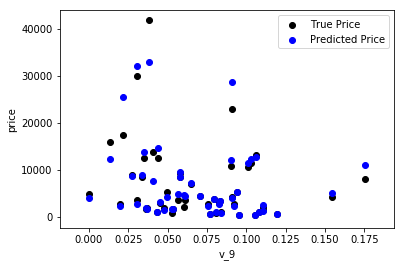

In [17]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

## 五折交叉验证 

在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。
因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（Cross Validation）

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [19]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [20]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


In [21]:
print('AVG:', np.mean(scores))

AVG: 1.3658023920313986


In [22]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


In [23]:
print('AVG:', np.mean(scores))

AVG: 0.1932530183704742


In [24]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


In [25]:
import datetime

In [26]:
sample_feature = sample_feature.reset_index(drop=True)

In [27]:
split_point = len(sample_feature) // 5 * 4

In [28]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [29]:
model = model.fit(train_X, train_y_ln)

In [30]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667270301014

In [31]:
from sklearn.model_selection import learning_curve, validation_curve

In [32]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from '/Users/Tevain/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

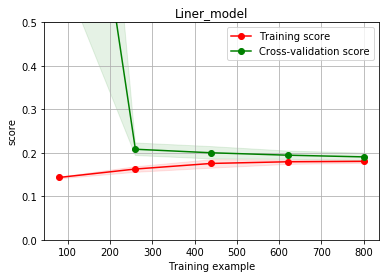

In [33]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

In [34]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [36]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [37]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [38]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.750749465615247


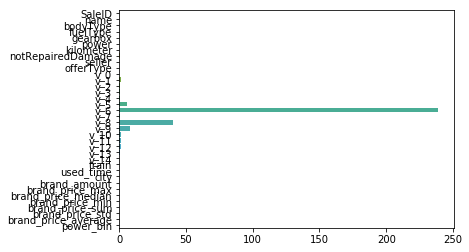

In [39]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:4.671709786963157


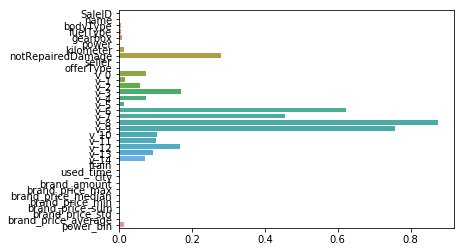

In [40]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:8.672182462666198


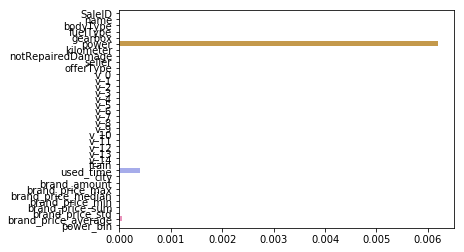

In [41]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
#from xgboost.sklearn import XGBRegressor
#from lightgbm.sklearn import LGBMRegressor

In [48]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100)]
   #       XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
    #      LGBMRegressor(n_estimators = 100)]

In [49]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished


In [50]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor
cv1,0.190792,0.198024,0.143487,0.168897,1823.403454
cv2,0.193758,0.192900,0.142674,0.171831,213.522075
cv3,0.194132,0.189868,0.142275,0.170929,150.339850
cv4,0.191825,0.188693,0.141971,0.169083,244.120139
cv5,0.195758,0.205301,0.147933,0.174094,312.406589
